# High-NA vectorial PSF generation

In [1]:
from typing import Optional, Tuple

import flax.linen as nn
import matplotlib.pyplot as plt
import numpy as np
from jax import random

from chromatix.elements import (
    # FFLens2,
    GaussianSource,
)
from chromatix.elements.lenses import FFLens2

key = random.PRNGKey(42)


%load_ext autoreload
%autoreload 2

In [6]:
class HighNAPSF(nn.Module):
    camera_shape: Tuple[int, int] = (256, 256)
    pupil_shape: Tuple[int, int] = (256, 256)
    camera_pixel_pitch: float = 0.005
    f: float = 100
    NA: float = 0.9
    n: float = 1.5
    wavelength: float = 0.532
    wavelength_ratio: float = 1.0
    upsample: int = 1
    pad: int = 0
    taper_width: Optional[float] = 0

    @nn.compact
    def __call__(self):
        # Some preliminaries
        shape = tuple(np.array(self.camera_shape) * self.upsample + self.pad)
        spacing = (
            self.upsample
            * self.f
            * self.wavelength
            / (self.n * shape[0] * self.camera_pixel_pitch)
        )
        field_pup = GaussianSource(
            self.pupil_shape,
            spacing,
            self.wavelength,
            self.wavelength_ratio,
            self.f,
            self.n,
            self.NA,
            power=1,
            amplitude=np.array([0.0, 0.0, 1.0]),
            scalar=False,
            envelope_waist=1,
        )(z=0)

        field = FFLens2(
            self.NA, self.camera_shape, self.camera_pixel_pitch, self.wavelength
        )(field_pup)
        return field, field_pup

0.016983635559486954
0.016983635559486954


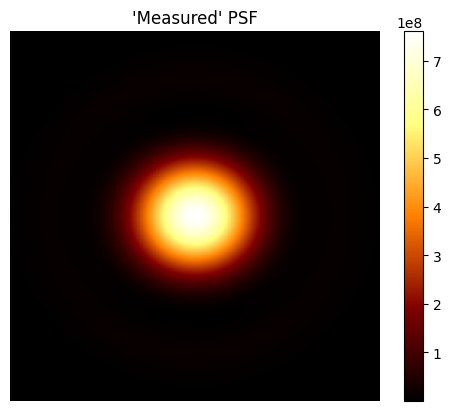

In [7]:
# Initialize model
model = HighNAPSF()
variables = model.init(key)
state = variables["state"]
del variables  # delete for memory

# Generating data
output_field, field_pup = model.apply({"state": state})
psf_truth = (np.abs(output_field.u) ** 2).sum(axis=-1)

plt.figure()
plt.imshow(psf_truth.squeeze(), cmap="afmhot")
plt.colorbar()
plt.title("'Measured' PSF")
plt.axis("off")
plt.show()

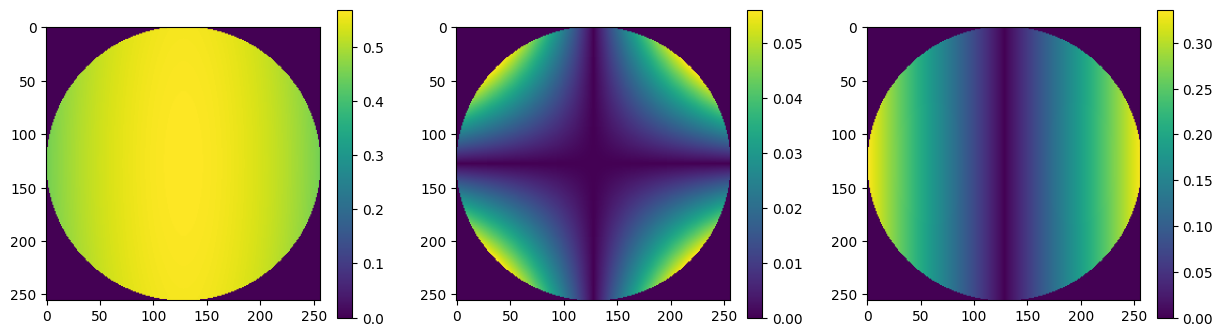

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(field_pup.u).squeeze()[:, :, 2])
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(np.abs(field_pup.u).squeeze()[:, :, 1])
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(np.abs(field_pup.u).squeeze()[:, :, 0])
plt.colorbar()
plt.show()

In [5]:
field_pup.shape

(1, 256, 256, 1, 3)